# Bibliotecas

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from statsmodels.api import OLS
import statsmodels.api as sm
from sklearn import set_config
import numpy as np
set_config(display='diagram')
from sklearn.linear_model import Ridge


In [25]:
y_val = pd.read_csv('..//y_values.csv')

df = pd.read_parquet('..//raw_data//coin_id_formated.parquet')
df.head()

,id,symbol,name,asset_platform_id,hashing_algorithm,categories,description,country_origin,sentiment_votes_up_percentage,sentiment_votes_down_percentage,market_cap_rank,coingecko_rank,coingecko_score,community_score,liquidity_score,twitter_followers,telegram_channel_user_count
0,01coin,zoc,zoc,nan,NeoScrypt,[Masternodes],,nan,NaN,NaN,NaN,2463,14.726,15.272,1.0,366.0,243.0
1,0-5x-long-algorand-token,algohalf,algohalf,ethereum,nan,[],0.5X Long Algorand Token (ALGOHALF) is an ERC2...,nan,NaN,NaN,NaN,12804,0.2,0.0,1.0,0.0,NaN
2,0-5x-long-altcoin-index-token,althalf,althalf,ethereum,nan,[],0.5X Long Altcoin Index Token (ALTHALF) is an ...,nan,NaN,NaN,NaN,13244,0.0,0.0,0.0,0.0,NaN
3,0-5x-long-ascendex-token-token,asdhalf,asdhalf,ethereum,nan,[],0.5X Long AscendEx Token (BTMX) Token (ASDHALF...,nan,NaN,NaN,NaN,13159,0.0,0.0,0.0,0.0,NaN
4,0-5x-long-bitcoin-cash-token,bchhalf,bchhalf,ethereum,nan,[],0.5X Long Bitcoin Cash Token (BCHHALF) is an E...,nan,NaN,NaN,NaN,12978,0.2,0.0,1.0,0.0,NaN


In [3]:
str_cols = ['id', 'symbol', 'name', 'asset_platform_id', 'hashing_algorithm','description','country_origin']
df[str_cols] = df[str_cols].astype(str)
float_cols = ['sentiment_votes_up_percentage', 'sentiment_votes_down_percentage','market_cap_rank', ]
df[float_cols] = df[float_cols].astype(float)
int_cols = ['coingecko_rank', 'coingecko_score','community_score', 'liquidity_score', 'twitter_followers',
       'telegram_channel_user_count']       
df[int_cols] = df[int_cols].astype(float)


### Analisando as categorias

In [4]:
df['categories'] = [
    x.tolist() if len(x.tolist()) != 0 else [None] for x in df['categories']
]
catHandler = pd.DataFrame(df['categories'].to_list(),
                          index=df['id']).values.ravel('K')

uniCats = pd.unique(catHandler)
uniCats = [x for x in uniCats if (x != None)]

df_cat_dummies = pd.DataFrame(index=df.id, columns=uniCats)

for coin, categories in df[['id', 'categories']].to_numpy():

    for categorie in categories:

        df_cat_dummies.loc[coin, categorie] = 1
        
df_cat_dummies.drop([None], axis=1, inplace=True)

In [5]:
df_cat_dummies = df_cat_dummies.fillna(0).astype(int)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 10))
df_cat_dummies.sum().plot(kind='bar')

In [ ]:
ecossystens = []
for x in df_cat_dummies.columns:
    if x.split()[-1] == 'Ecosystem':
        ecossystens.append(x)
        print(x)

In [ ]:
df_cat_dummies[ecossystens].sum().plot(kind='bar')

In [33]:
df_cat_dummies.to_parquet("../raw_data/dummy_categories.parquet.gzip")

In [7]:
df_completo_categorias = df.merge(df_cat_dummies, left_on="id", right_index=True).drop("categories", axis=1)

In [35]:
df_completo_categorias.to_parquet("../raw_data/coin_id_with_categories.parquet.gzip")

In [34]:
y_val = y_val.replace([np.inf, -np.inf], np.nan).fillna(0)

In [35]:
df_completo_y = df_completo_categorias.merge(y_val, left_on='id', right_on='Unnamed: 0').drop("Unnamed: 0", axis=1)
df_completo_y.to_parquet("../coin_COMPLETO.parquet.gzip")

## Modelo de Regressao

In [11]:
df_completo_y = pd.read_parquet("../coin_COMPLETO.parquet.gzip")

###  Analise de Variaveis

In [12]:
df_completo_y.describe()


,sentiment_votes_up_percentage,sentiment_votes_down_percentage,market_cap_rank,coingecko_rank,coingecko_score,community_score,liquidity_score,twitter_followers,telegram_channel_user_count,Masternodes,...,GBP Stablecoin,NFT Index,launch_price,0days_price,4days_price,16days_price,28days_price,90days_price,180days_price,360days_price
count,5388.000000,5388.000000,3793.000000,13110.000000,13241.000000,13241.000000,13241.000000,1.324100e+04,1.110500e+04,13241.000000,...,13241.000000,13241.000000,1.324100e+04,1.318700e+04,1.313400e+04,1.288700e+04,1.252900e+04,1.111400e+04,7778.000000,4.603000e+03
mean,72.636611,27.363400,1907.529133,6686.260564,7.963948,11.003455,6.053937,3.887708e+04,1.170131e+04,0.008156,...,0.000076,0.000378,3.155201e+09,inf,inf,inf,inf,inf,inf,3.746004e+08
std,34.599060,34.599059,1127.557862,3910.932547,9.306983,9.828820,12.036557,2.530246e+05,2.973868e+04,0.089948,...,0.008690,0.019429,3.630488e+11,NaN,NaN,NaN,NaN,NaN,NaN,2.541492e+10
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,2.000000e+00,0.000000,...,0.000000,0.000000,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-3.717057,-1.000000e+00
25%,50.000000,0.000000,950.000000,3289.250000,1.826000,6.373000,1.000000,4.840000e+02,9.690000e+02,0.000000,...,0.000000,0.000000,1.314000e-03,-4.182897e-02,-3.291565e-01,-5.593921e-01,-7.005223e-01,-8.829086e-01,-0.902389,-9.425079e-01
50%,87.500000,12.500000,1903.000000,6621.500000,4.013000,8.644000,1.000000,5.344000e+03,3.202000e+03,0.000000,...,0.000000,0.000000,6.995000e-02,0.000000e+00,-8.182321e-02,-2.250698e-01,-3.694761e-01,-6.153846e-01,-0.630046,-6.982026e-01
75%,100.000000,50.000000,2853.000000,10105.500000,12.032000,10.830000,3.453000,2.512800e+04,1.103700e+04,0.000000,...,0.000000,0.000000,1.070000e+00,0.000000e+00,7.478133e-02,8.330744e-02,5.223881e-02,-1.376372e-03,0.073769,9.368835e-02
max,100.000000,100.000000,13284.000000,13510.000000,81.034000,85.250000,106.715000,1.186877e+07,1.432776e+06,1.000000,...,1.000000,1.000000,4.177586e+13,inf,inf,inf,inf,inf,inf,1.724286e+12


<AxesSubplot:ylabel='Frequency'>

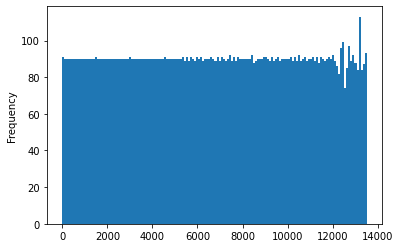

In [39]:
df[df['coingecko_rank'] != 0]['coingecko_rank'].plot(kind='hist', bins=150)


<AxesSubplot:ylabel='Frequency'>

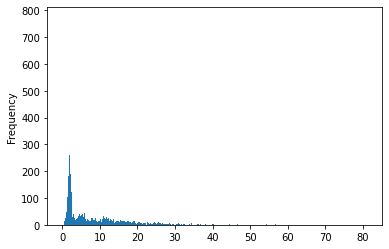

In [24]:
df[df['coingecko_score'] != 0]['coingecko_score'].plot(kind='hist', bins=1500)


<AxesSubplot:ylabel='Frequency'>

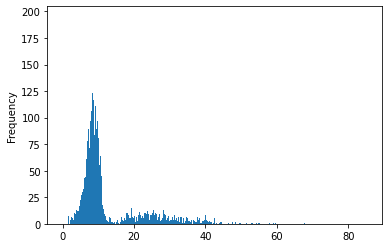

In [25]:
df[df['community_score'] != 0]['community_score'].plot(kind='hist', bins=1500)


<AxesSubplot:ylabel='Frequency'>

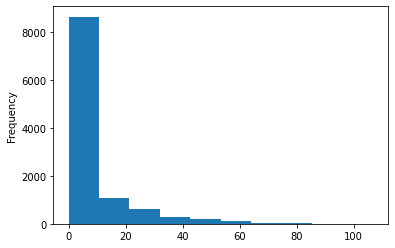

In [32]:
df[df['liquidity_score'] != 0]['liquidity_score'].plot(kind='hist')


<AxesSubplot:ylabel='Frequency'>

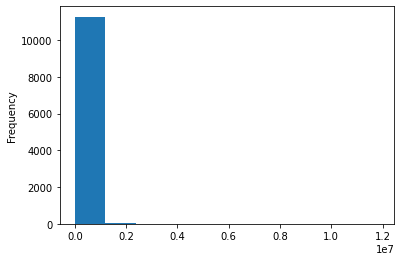

In [33]:
df[df['twitter_followers'] != 0]['twitter_followers'].plot(kind='hist')


### Build Pipeline

#### Caso queira customizar alguma função

In [ ]:
def multiply(df):
    return pd.DataFrame(df['product_length_cm'] * df['product_height_cm'] *
                        df['product_width_cm'])


volume_computer = Pipeline([('compute_volume', FunctionTransformer(multiply)),
                            ('scale_volume', MinMaxScaler())])

final_preprocessor = ColumnTransformer([
    ('num_encoder', MinMaxScaler(),
     make_column_selector(dtype_include="int64")),
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False),
     make_column_selector(dtype_include="object")),
    ('volume_computer', volume_computer,
     ['product_length_cm', 'product_height_cm', 'product_width_cm'])
])

pipe = Pipeline([('preprocessing', final_preprocessor),
                 ('linear_regression', Ridge())])

pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_encoder', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe948dc6c10>),
                                                 ('cat_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe948dc6dc0>),
                                                 ('volume_computer',
                                                  Pipeline(steps=[('compute_volume',
                                                                   FunctionTransformer(func=<function multiply at 0x7fe948e761f0>)),
                                                                  ('scale_volume',
                                                                   MinMaxScaler())]),
                                                  ['product_length_cm',
                                                   'product_height_cm',
                                                   'product_width_cm'])])),
                ('linear_regression', Ridge())])

#### Caso use as padrões

In [15]:
df_completo_y.describe()

,sentiment_votes_up_percentage,sentiment_votes_down_percentage,market_cap_rank,coingecko_rank,coingecko_score,community_score,liquidity_score,twitter_followers,telegram_channel_user_count,Masternodes,...,GBP Stablecoin,NFT Index,launch_price,0days_price,4days_price,16days_price,28days_price,90days_price,180days_price,360days_price
count,5388.000000,5388.000000,3793.000000,13110.000000,13241.000000,13241.000000,13241.000000,1.324100e+04,1.110500e+04,13241.000000,...,13241.000000,13241.000000,1.324100e+04,1.318700e+04,1.313400e+04,1.288700e+04,1.252900e+04,1.111400e+04,7778.000000,4.603000e+03
mean,72.636611,27.363400,1907.529133,6686.260564,7.963948,11.003455,6.053937,3.887708e+04,1.170131e+04,0.008156,...,0.000076,0.000378,3.155201e+09,inf,inf,inf,inf,inf,inf,3.746004e+08
std,34.599060,34.599059,1127.557862,3910.932547,9.306983,9.828820,12.036557,2.530246e+05,2.973868e+04,0.089948,...,0.008690,0.019429,3.630488e+11,NaN,NaN,NaN,NaN,NaN,NaN,2.541492e+10
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,2.000000e+00,0.000000,...,0.000000,0.000000,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-3.717057,-1.000000e+00
25%,50.000000,0.000000,950.000000,3289.250000,1.826000,6.373000,1.000000,4.840000e+02,9.690000e+02,0.000000,...,0.000000,0.000000,1.314000e-03,-4.182897e-02,-3.291565e-01,-5.593921e-01,-7.005223e-01,-8.829086e-01,-0.902389,-9.425079e-01
50%,87.500000,12.500000,1903.000000,6621.500000,4.013000,8.644000,1.000000,5.344000e+03,3.202000e+03,0.000000,...,0.000000,0.000000,6.995000e-02,0.000000e+00,-8.182321e-02,-2.250698e-01,-3.694761e-01,-6.153846e-01,-0.630046,-6.982026e-01
75%,100.000000,50.000000,2853.000000,10105.500000,12.032000,10.830000,3.453000,2.512800e+04,1.103700e+04,0.000000,...,0.000000,0.000000,1.070000e+00,0.000000e+00,7.478133e-02,8.330744e-02,5.223881e-02,-1.376372e-03,0.073769,9.368835e-02
max,100.000000,100.000000,13284.000000,13510.000000,81.034000,85.250000,106.715000,1.186877e+07,1.432776e+06,1.000000,...,1.000000,1.000000,4.177586e+13,inf,inf,inf,inf,inf,inf,1.724286e+12


In [13]:


final_preprocessor = ColumnTransformer([
    ('num_encoder', MinMaxScaler(),
     make_column_selector(dtype_include="float64")),

    ('cat_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False),
     make_column_selector(dtype_include="object"))])

pipe = Pipeline([('preprocessing', final_preprocessor),
                 ('linear_regression', Ridge())])

pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_encoder', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe3dca22dc0>),
                                                 ('cat_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe3dca22fa0>)])),
                ('linear_regression', Ridge())])

In [14]:
pipe.fit_transform(df_completo_y)

ValueError: Input contains infinity or a value too large for dtype('float64').